In [1]:
import os
import warnings
from dotenv import load_dotenv

load_dotenv()
warnings.filterwarnings("ignore")

OPENAI_KEY = os.getenv("OPENAI_API_KEY")
HUGGINGFACE_API = os.getenv("HUGGINGFACE_API_KEY")
PINECONE_KEY = os.getenv("PINECONE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini-2025-04-14", api_key = OPENAI_KEY)

In [3]:
llm.invoke("Hi").content

'Hello! How can I assist you today?'

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone

from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition

from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

In [5]:
# Embedding Model
model_name = "abhinand/MedEmbed-large-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=HUGGINGFACE_API)
model = AutoModel.from_pretrained(model_name, token=HUGGINGFACE_API)

def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Pooling the token embeddings
    return embeddings.squeeze().tolist()  # Ensure the output is a flat list

class CustomEmbeddings:
    def embed_query(self, query: str):
        return generate_embeddings(query)

embedding_model = CustomEmbeddings()

# Chaecking embedding size. It should be 1024. Since, our PineconeDB has 1024 embedding size we need to query user question to 1024 dim
len(embedding_model.embed_query("hi"))

1024

In [6]:
# Initializing the Retriever

pc = Pinecone(api_key=PINECONE_KEY)
index = pc.Index("personal-test-1")
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embedding_model,
    text_key="text",
    namespace=None
)

In [7]:
# Testing the vectorstore

query = 'Give the table of lysosomal storage disorders'

results = vectorstore.similarity_search_with_relevance_scores(query,k=10)

print(results[0][0].page_content)

86 SECTION II BIOCHEmISTRY ` BIOCHEMISTRY—METABOlISM BIOCHEmISTRY ` BIOCHEMISTRY—METABOlISM Lysosomal storage Lysosomal enzyme deficiency  accumulation of abnormal metabolic products.  incidence of diseases Tay-Sachs, Niemann-Pick, and some forms of Gaucher disease in Ashkenazi Jews. DISEASE FINDINGS DEFICIENT ENZYME ACCUMUlATED SUBSTRATE INHERITANCE Sphingolipidoses Tay-Sachs disease Progressive neurodegeneration, Hexosaminidase A GM ganglioside. AR 2 A developmental delay, hyperreflexia, (“TAy-Sax”). hyperacusis, “cherry-red” spot on macula A (lipid accumulation in ganglion cell layer), lysosomes with onion skin, no hepatosplenomegaly (vs Niemann-Pick). Fabry disease Early: triad of episodic peripheral α-galactosidase A. Ceramide XR B neuropathy, angiokeratomas B, trihexoside hypohidrosis. (globotriaosylce- Late: progressive renal failure, ramide). cardiovascular disease. Metachromatic Central and peripheral demyelination Arylsulfatase A. Cerebroside sulfate. AR leukodystrophy with

In [8]:
retriever=vectorstore.as_retriever()

In [9]:
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_medical_knowledge",
    description=(
        "Search and return authoritative medical information from the Pinecone vector store. "
        "The index contains peer-reviewed clinical studies, treatment guidelines, drug monographs, "
        "and other curated healthcare content. Invoke this tool **only** when the user explicitly asks a medical-related "
        "question requiring sourced data from the index (e.g., disease mechanisms, therapy options, statistics, references). "
        "For any non-medical query, casual greeting (‘hi’, ‘hello’, ‘how are you’), or general conversation, respond directly "
        "without using this tool."
    ),
)

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults(api_key=TAVILY_API_KEY)

In [11]:
tools=[retriever_tool]
retrieve=ToolNode([retriever_tool])

In [ ]:
# ===== 3.  Core prompts =====
SYSTEM_PROMPT = """
    You are a highly experienced medical professor with deep expertise in all areas of medicine, 
    including clinical care, research, and teaching. 
    You are known for your ability to explain complex medical concepts in a simple, clear, and comprehensive way. 
    Answer the following question based only on the provided context and any relevant information retrieved 
    from the vector database (vectordb) to enhance your response. Think step by step before providing a detailed answer.

    **Before answering, retrieve and consider relevant contexts 
    stored in the vector database (vectordb) for better results.**  
                     
    <context>
    {context}
    </context>
                              
    When answering questions, follow these guidelines:

      1. **If the question asks about a single medical concept**:
         - Introduce the topic clearly.
         - Break down the explanation into core components:
            - Definition
            - Causes and Risk Factors
            - Symptoms
            - Diagnosis Methods
            - Treatment Options
            - Prevention
            - Prognosis
         - Provide examples and analogies where appropriate.
         - Summarize the key points at the end.

      2. **If the question asks to compare or differentiate between two medical concepts**:
         - Introduce both concepts briefly.
         - Compare them across multiple key components:
            - Definitions: Explain the definition of both concepts.
            - Causes and Risk Factors: Highlight the causes and risk factors of each.
            - Symptoms: Compare how symptoms manifest in each condition.
            - Diagnosis Methods: Describe how the diagnosis differs between them.
            - Treatment Options: Compare available treatment methods for both.
            - Prognosis: Explain how the outlook or recovery differs.
         - Use analogies or comparisons to make the differences clearer.
         - Provide real-world examples for each condition.
         - Conclude with a concise summary of the key differences and similarities.
                
      3. **If the question is a multiple-choice question (MCQ) or if you are given any options for a question**:
         - **Before answering, retrieve relevant contexts from the vector database (vectordb) to support your reasoning.**
         - **Begin by carefully reading the question and all the answer options.**
         - **Start your response with:** "Let's analyze the question step by step."
         - **Break down the question to identify key information:**
           - Patient demographics (age, gender)
           - Presenting symptoms and their duration
           - Relevant medical history
           - Any specific findings from physical examinations or tests
         - **Provide a detailed explanation of what the problem is about, explaining the solutions in detail like a medical professor.**
         - **Use a logical chain-of-thought to reason through the problem:**
           - Consider the most likely diagnoses based on the presented information.
           - Apply relevant medical knowledge, such as anatomy, physiology, pathology, and clinical correlations.
           - Think about potential mechanisms or processes that explain the symptoms.
         - **Systematically evaluate each answer option:**
           - **For each option:**
             - Explain the medical concept it represents.
             - Discuss whether it aligns or conflicts with the key information from the question.
             - Provide reasoning for why it is correct or incorrect.
             - Go into detail about the topic the correct answer is about.
         - **Highlight the key points that lead to the correct choice.**
         - **After thorough analysis, conclude with the correct answer:**
           - Clearly state the correct option, e.g., "Therefore, the correct answer is Option A: [Answer]."
         - **Summarize the key points that led to the correct choice.**
         - **Provide additional insights or clinical pearls related to the topic if appropriate.**
         - **Compare all the options, going into detail as needed to explain those topics.**
         - **Conclude with a summary, reinforcing why the correct choice is the best answer.**
         - **Maintain an educational tone throughout, as if teaching a medical student.**

      4. **If providing data in a table**:
         - Format the table using proper Markdown syntax.
         - Ensure each row contains all relevant data without leaving cells blank.
         - Repeat labels in each row as needed for readability, especially for complex data.
         - Try to maintain uniformaty in the table, if possible. And tyr to maintain uniform distance between datapoints.
         - Summarize the key findings from the table in the table at the end.
         - Explain the data in the table in the text, if needed.

         - Use this format for tables:

            | Column 1 Header | Column 2 Header | Column 3 Header | Column 4 Header  |
            |-----------------|-----------------|-----------------|------------------|
            | Row 1 Data 1    | Row 1 Data 2    | Row 1 Data 3    | Row  1 Data 4    |
            | Row 2 Data 1    | Row 2 Data 2    | Row 2 Data 3    | Row  2 Data 4    |


         - If any cells are missing data, state "N/A" instead of leaving them blank.
         - Ensure consistent alignment and full data entries per row to maintain visual clarity.

                
      - Adjust your use of medical jargon depending on the audience: simplify for patients and 
                              use more technical terms for students.
      - Always be empathetic and respectful, as though you are talking to a medical student or a patient 
                              who is eager to learn and understand the medical information.

    If the provided context or question lacks clarity, ask for clarification before giving a complete answer.
                              
"""

ASSISTANT_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", SYSTEM_PROMPT),
        ("human", "{question}")
    ]
)

RAG_PROMPT = PromptTemplate(
    template=(
        SYSTEM_PROMPT
        + "\n\n<context>\n{context}\n</context>\n\n"
        + "Question: {question}\nAnswer step-by-step:"
    ),
    input_variables=["context", "question"],
)

GRADER_PROMPT = PromptTemplate(
    template=(
        "You are a grader deciding if a retrieval context answers the question.\n"
        "Context: {context}\n\nQuestion: {question}\n\n"
        "Respond with exactly 'yes' or 'no'."
    ),
    input_variables=["context", "question"],
)

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
def tavily_search(state: AgentState) -> AgentState:
    """Run a Web search when the vector store has no hits."""
    print("---TAVILY WEB SEARCH---")
    question = state["messages"][0].content
    snippets = tavily.invoke(question)           # → list[str]
    joined   = "\n\n---\n\n".join(snippets)
    return {"messages": [AIMessage(content=joined)]}

In [15]:
from langchain_core.tools import StructuredTool
def ai_assistant(state: AgentState):
    """Entry-point node: decide whether to call tools."""
    messages = state["messages"]

    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content

        chain = ASSISTANT_PROMPT | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [16]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [17]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter", "Tavily_Search"]:
    """Route based on doc availability **and** relevance."""

    question = state["messages"][0].content
    docs     = state["messages"][-1].content        # string after join()

    # ①  If retriever found nothing → Web search
    if docs.strip() == "":
        print("---NO DOCS FOUND → WEB SEARCH---")
        return "Tavily_Search"

    # Otherwise grade relevance
    llm_with_structure_op=llm.with_structured_output(grade)
    
    chain = GRADER_PROMPT | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score.lower()

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [25]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    rag_chain = RAG_PROMPT | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    
    return {"messages": [response]}

In [26]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Rewrite this question so that a retrieval system can fetch the most relevant "
        "clinical information.\nOriginal: {question}\nRewritten:""")
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [27]:
workflow=StateGraph(AgentState)

workflow.add_node("AI_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)
workflow.add_node("Tavily_Search", tavily_search)

workflow.add_edge(START,"AI_Assistant")

workflow.add_conditional_edges("AI_Assistant",
                            tools_condition,
                            {"tools": "Vector_Retriever",
                                END: END,})

workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter",
                            "tavily_search": "Tavily_Search"
                            }
                            )

workflow.add_edge("Tavily_Search", "Output_Generator")
workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "AI_Assistant")


graph=workflow.compile()

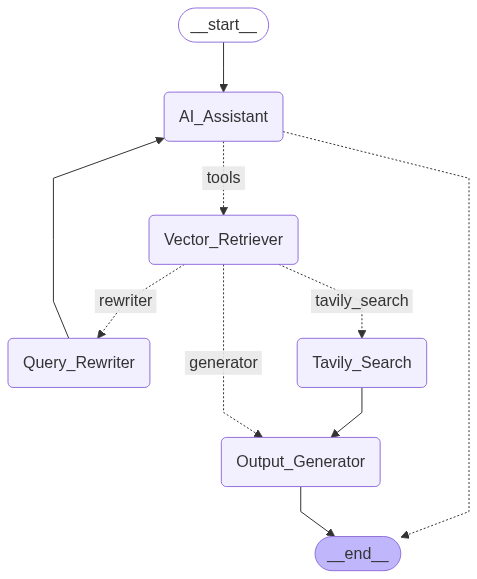

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
response = graph.invoke({"messages":["Give the table of lysosomal storage disorders"]})

---DECISION: DOCS RELEVANT---
---GENERATE---


In [30]:
print(response["messages"][-1].content)

Step 1: Identify the lysosomal storage disorders (LSDs) from the provided context.

The context lists several LSDs under categories such as sphingolipidoses and mucopolysaccharidoses.

Step 2: Extract key information for each LSD:
- Disease name
- Clinical findings
- Deficient enzyme
- Accumulated substrate
- Inheritance pattern

Step 3: Organize the extracted information into a clear table format.

---

**Table of Lysosomal Storage Disorders**

| Disease                  | Clinical Findings                                                                                           | Deficient Enzyme               | Accumulated Substrate                     | Inheritance Pattern          |
|--------------------------|------------------------------------------------------------------------------------------------------------|-------------------------------|-------------------------------------------|-----------------------------|
| **Tay-Sachs disease**    | Progressive neurodegeneration,

In [45]:
question=''' 
A 76-year-old African American man presents to his primary care 
provider complaining of urinary frequency. He wakes up 3-4 times per night 
to urinate while he previously only had to wake up once per night. He also 
complains of post-void dribbling and difficulty initiating a stream of 
urine. He denies any difficulty maintaining an erection. His past medical 
history is notable for non-alcoholic fatty liver disease, hypertension, 
hyperlipidemia, and gout. He takes aspirin, atorvastatin, enalapril, and 
allopurinol. His family history is notable for prostate cancer in his 
father and lung cancer in his mother. He has a 15-pack-year smoking 
history and drinks alcohol socially. On digital rectal exam, his prostate 
is enlarged, smooth, and non-tender. Which of the following medications is 
indicated in this patient? 
Options: 
A: Clonidine, 
B: Hydrochlorothiazide, 
C: Midodrine, 
D: Oxybutynin, 
E: Tamsulosin 
'''
response = graph.invoke({"messages":[question]})
print(response["messages"][-1].content)

---DECISION: DOCS RELEVANT---
---GENERATE---
Step 1: Analyze the patient's presentation and symptoms  
- The patient is a 76-year-old man with urinary frequency, nocturia (waking up 3-4 times per night to urinate), post-void dribbling, and difficulty initiating urination.  
- These symptoms suggest lower urinary tract obstruction or dysfunction, most consistent with benign prostatic hyperplasia (BPH), especially given his age (>50 years).  
- Digital rectal exam shows an enlarged, smooth, non-tender prostate, typical of BPH (not prostate cancer, which tends to be hard and nodular).  
- No signs of infection (no pain, tenderness) or other causes of urinary symptoms.  

Step 2: Understanding BPH pathophysiology and clinical features  
- BPH is hyperplasia (not hypertrophy) of the transition zone of the prostate, compressing the urethra and causing obstructive urinary symptoms: hesitancy, weak stream, post-void dribbling, nocturia, and frequency.  
- It commonly presents in men >50 years 